In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Introduction and data analysis 
Describe the problem being addressed. Provide a detailed characterization of the task dataset in terms of format, volume, quality and bias.

* Problem Description: 
> Start by introducing the problem or research question that your analysis aims to address. Clearly define the scope and objectives of your analysis. Explain why this problem is important or relevant.

* Dataset Description:

> Format: 
>> Describe the format of the dataset. Is it structured (e.g., CSV, Excel) or unstructured (e.g., text, images)? Mention the data types present (e.g., numerical, categorical). 

> Volume: 
>> Specify the size of the dataset in terms of the number of records and features (columns). Mention if it's a small, medium, or large dataset.

> Quality: 
>> Discuss the quality of the dataset. Are there missing values, outliers, or data errors? How were these issues handled (e.g., data imputation, outlier removal)?

> Bias: 
>> Address any potential biases in the dataset. Bias can arise from data collection methods, sampling, or other factors. Describe how bias was considered and handled, if applicable.

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Given the above statistical analysis. A very intriguing question arises. Is it possible for the columns including "Glucose", "BloodPressure", "SkinThickness", "Insulin", and "BMI" to have minimum value of zero? The value of zero doesn't make sense. For example, a person with BMI means a person weight zero kilogram. It is possible that those instances were treated as missing value (replace with zero) or recording error from human.

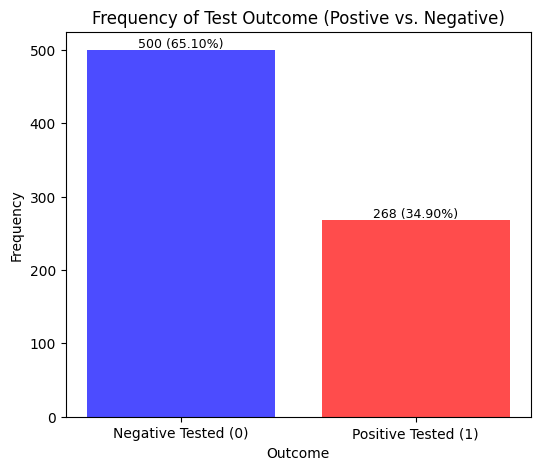

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

outcome_counts = df['Outcome'].value_counts()

total_count = outcome_counts.sum()

plt.figure(figsize=(6, 5))
plt.bar(x=[0, 1], height=outcome_counts, color=['blue', 'red'], alpha=0.7)
plt.title('Frequency of Test Outcome (Postive vs. Negative)')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Negative Tested (0)', 'Positive Tested (1)'], rotation=0)

for i, (count, percentage) in enumerate(zip(outcome_counts, outcome_counts / total_count * 100)):
    plt.text(i, count, f'{count} ({percentage:.2f}%)', ha='center', va='bottom', fontsize=9)

plt.show()


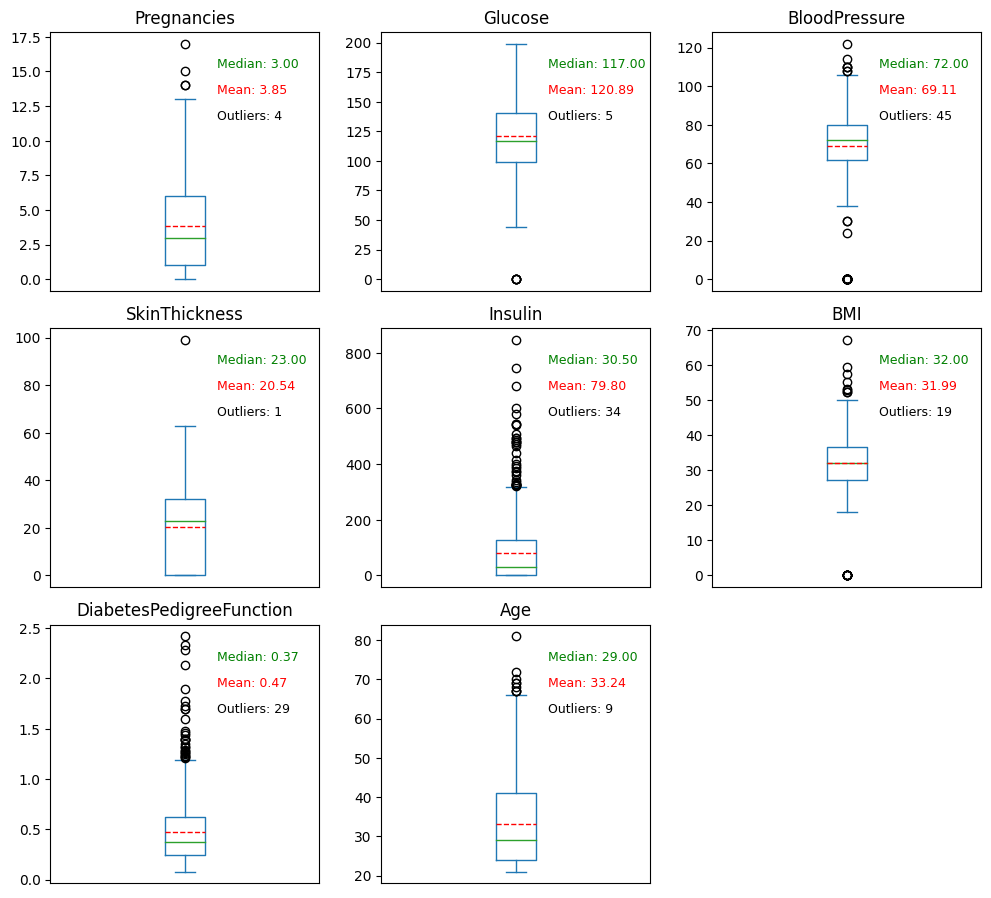

In [5]:
num_columns = len(df.drop(['Outcome'],axis=1).columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.drop(['Outcome'],axis=1).columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False, 
                           meanline=True, showmeans =True, meanprops={'color': 'red', 'linestyle': '--'})
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate the median and mean
    median, mean = df[col].median(), df[col].mean() 
    
    # Mean and Median Annotation
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',color='green')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',color='red')

    # Outlier calculation and Annotation
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


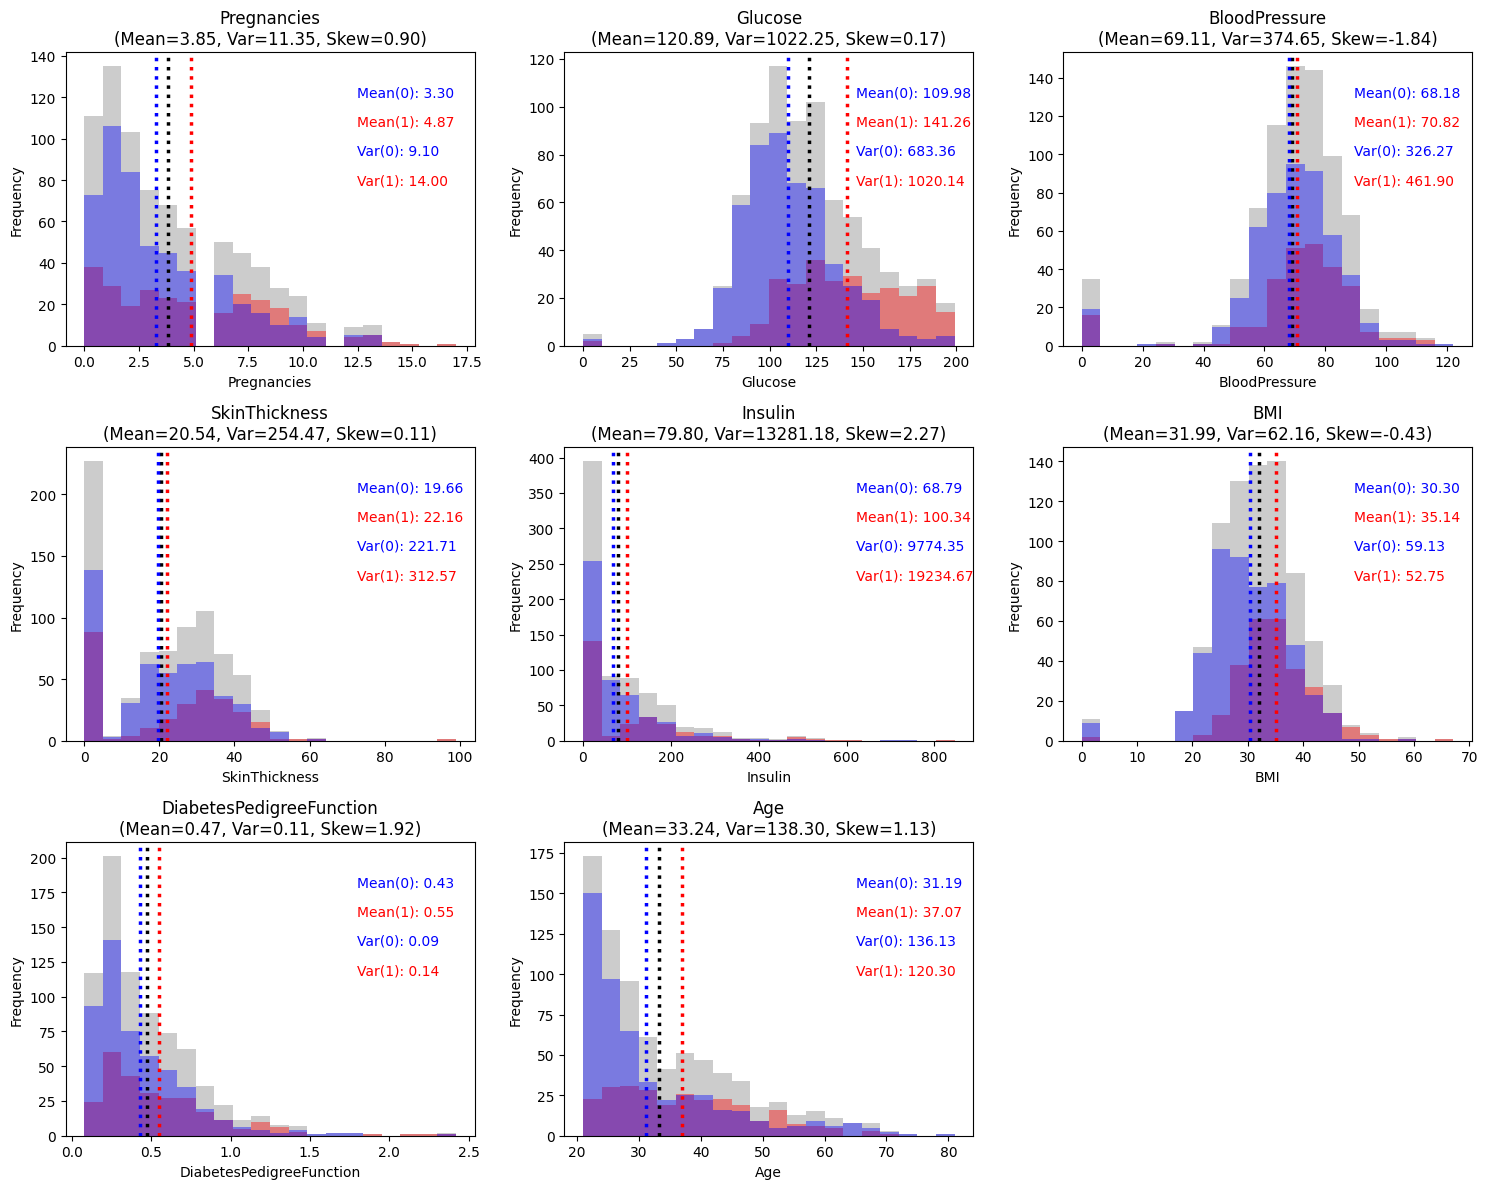

In [6]:
num_features = len(df.columns) - 1  
num_rows,num_cols = 3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8 * num_rows // 2))
axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):
    ax = axes[i]
    # Plot All the data points
    sns.histplot(data=df, x=column, bins=20, common_norm=False, ax=ax, 
                 legend=False, color='black', alpha=0.2, edgecolor='none')
    
    # Plot the data points seperated by hue (Outcome)
    sns.histplot(data=df, x=column, hue="Outcome", bins=20, common_norm=False, 
                 ax=ax, legend=False, palette={0: 'blue', 1: 'red'}, alpha=0.4, edgecolor='none')
    
    mean = df[column].mean()
    var = df[column].var()
    skew = df[column].skew()
    
    ax.set_title(f'{column}\n(Mean={mean:.2f}, Var={var:.2f}, Skew={skew:.2f})')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    
    
    mean_0 = df[df['Outcome'] == 0][column].mean()
    mean_1 = df[df['Outcome'] == 1][column].mean()
    var_0 = df[df['Outcome'] == 0][column].var()
    var_1 = df[df['Outcome'] == 1][column].var()

    ax.annotate(f'Mean(0): {mean_0:.2f}', xy=(0.7125, 0.85), xycoords='axes fraction', fontsize=10, color='blue')
    ax.annotate(f'Mean(1): {mean_1:.2f}', xy=(0.7125, 0.75), xycoords='axes fraction', fontsize=10, color='red')
    ax.annotate(f'Var(0): {var_0:.2f}', xy=(0.7125, 0.65), xycoords='axes fraction', fontsize=10, color='blue')
    ax.annotate(f'Var(1): {var_1:.2f}', xy=(0.7125, 0.55), xycoords='axes fraction', fontsize=10, color='red')
    
    ax.axvline(mean, color='black', linestyle='dotted', linewidth=2.5)
    ax.axvline(df[df['Outcome'] == 0][column].mean(), color='blue', linestyle='dotted', linewidth=2.5)
    ax.axvline(df[df['Outcome'] == 1][column].mean(), color='red', linestyle='dotted', linewidth=2.5)

for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

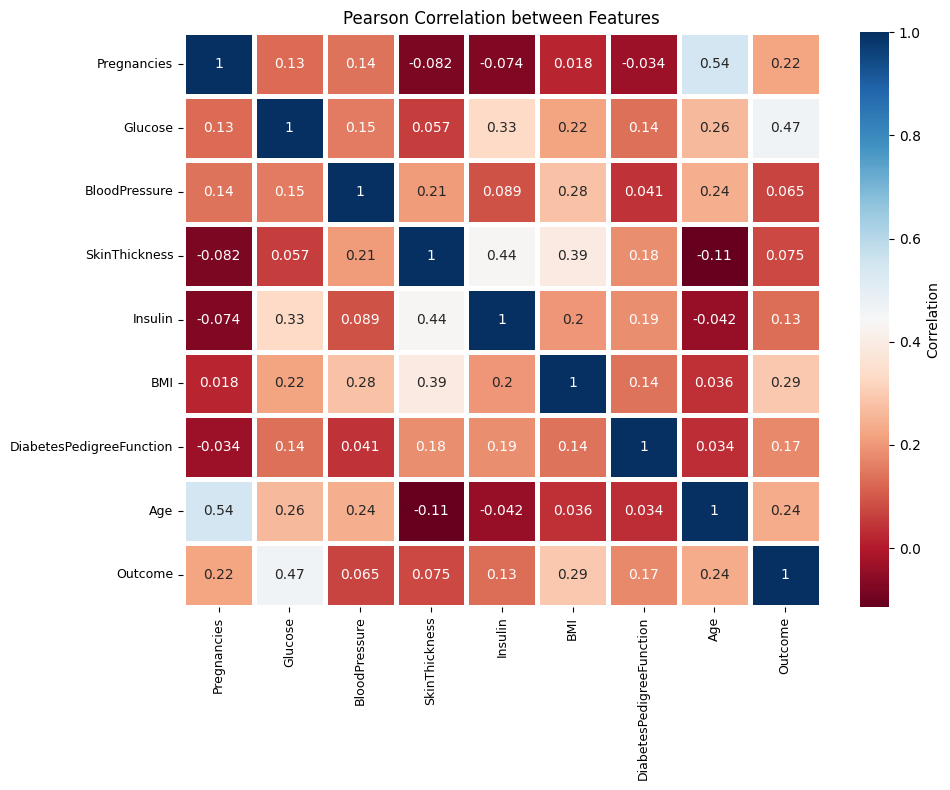

In [7]:
import seaborn as sns

plt.figure(figsize=(10, 8))
hmap = sns.heatmap(df.corr(), annot=True, cmap='RdBu', linewidths=3.5, linecolor='white')

# Add a title
plt.title("Pearson Correlation between Features")

hmap.set_xticklabels(hmap.get_xticklabels(), rotation=90, fontsize=9)
hmap.set_yticklabels(hmap.get_yticklabels(), fontsize=9)

# Customize the legend
cbar = hmap.collections[0].colorbar
cbar.set_label('Correlation', fontsize=10)
cbar.ax.tick_params(labelsize=10)

# Add additional artistic elements
plt.tight_layout()
plt.show()

### NOTE

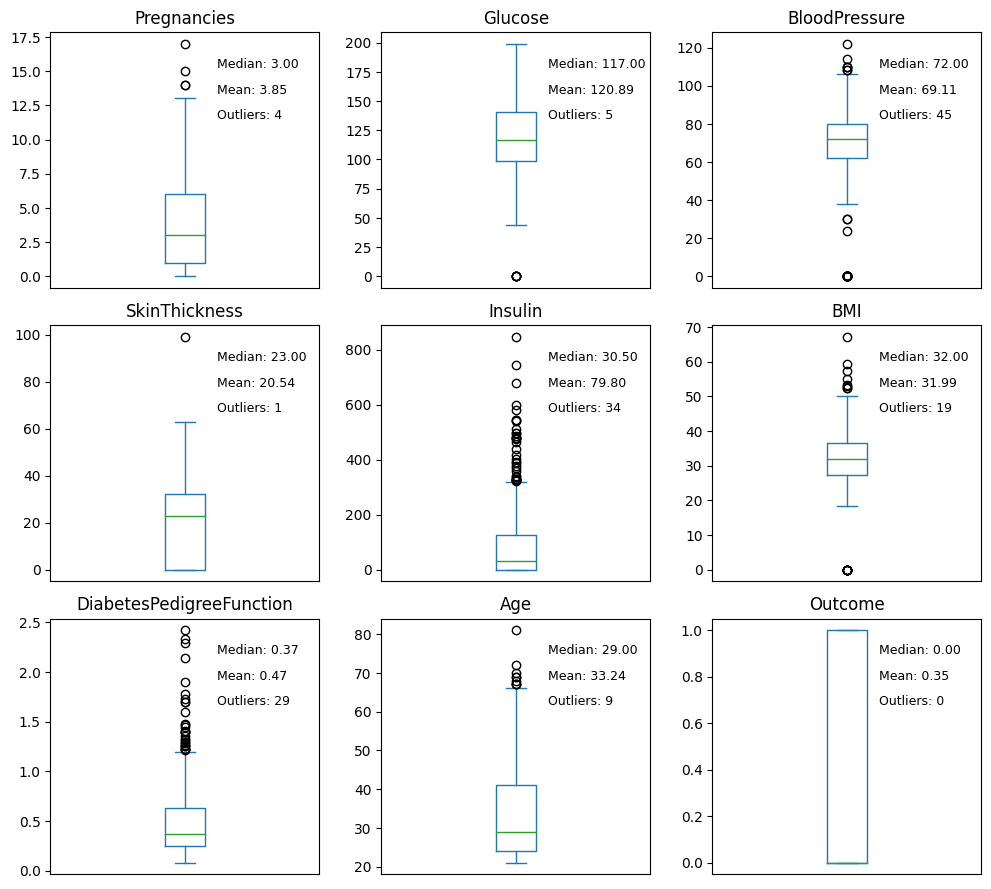

In [8]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate and annotate the median and mean
    median = df[col].median()
    mean = df[col].mean()
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    # Calculate and annotate the count of outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

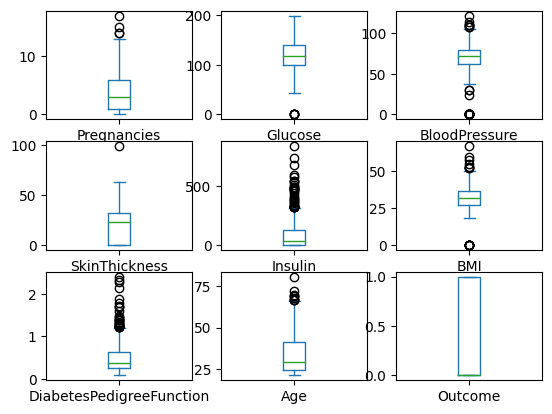

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

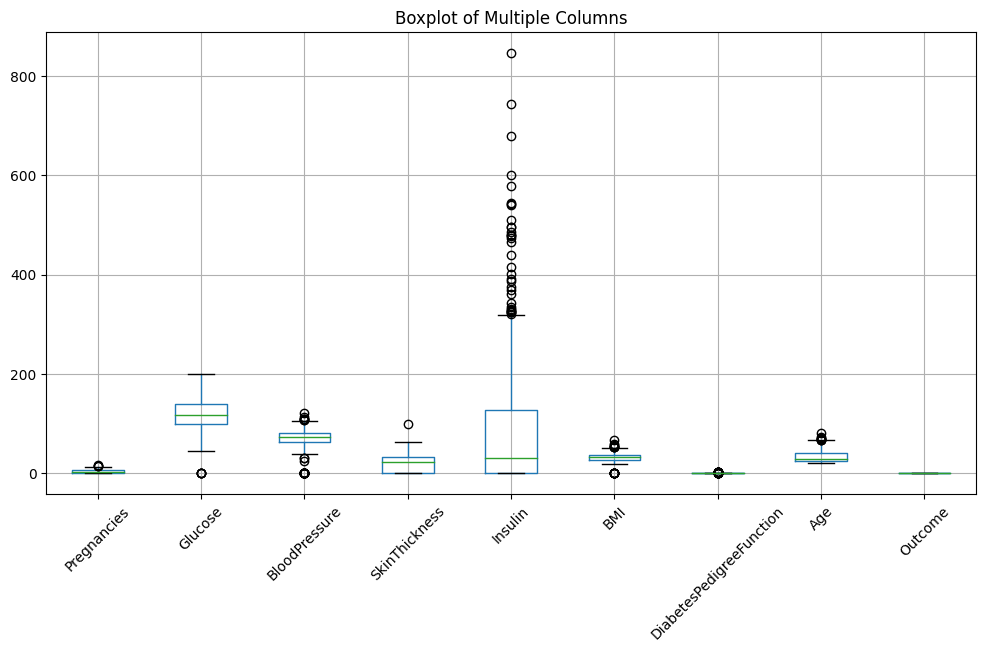

In [10]:
# Assuming your DataFrame is named 'df'
df.boxplot(figsize=(12, 6))  # You can adjust the figsize as needed
plt.title('Boxplot of Multiple Columns')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

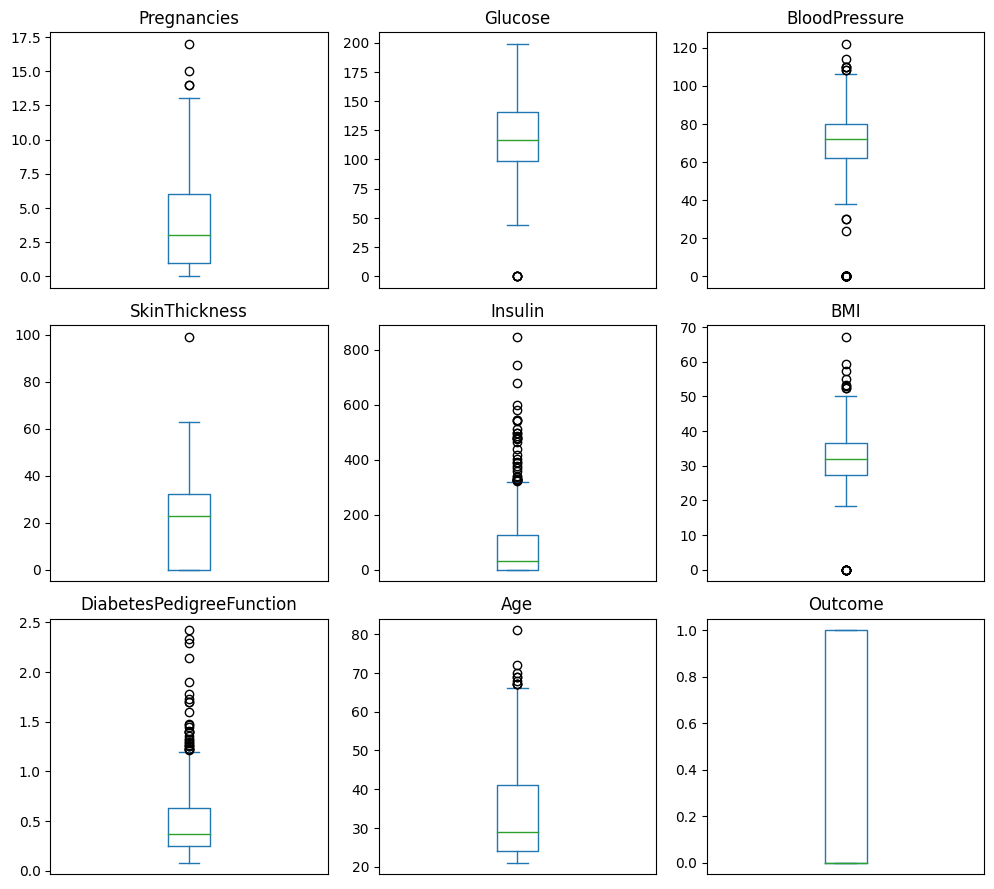

In [11]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows//2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and display
plt.tight_layout()
plt.show()


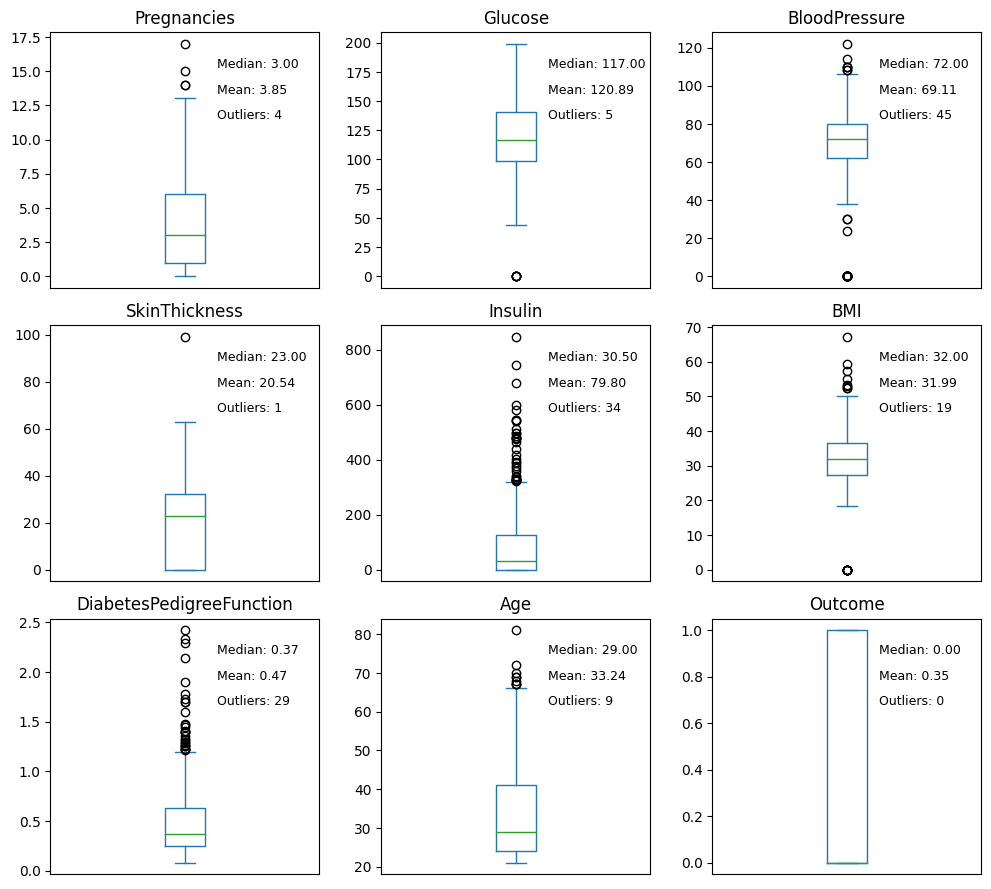

In [12]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 6 * num_rows // 2))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False)
    ax.set_title(f'{col}')
    ax.set_xticks([])

    # Calculate and annotate the median and mean
    median = df[col].median()
    mean = df[col].mean()
    ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')
    ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    # Calculate and annotate the count of outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()